In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
import seaborn as sns
from keras.optimizers import Adam
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

## Reading and analysing data

In [128]:

import pandas as pd
path="/content/drive/MyDrive/b-11 major project/metadata_allvisits.csv"
df = pd.read_csv(path)
path1="/content/drive/MyDrive/b-11 major project/metadata_allvisitsfluency.csv"
df1 = pd.read_csv(path1)
path2="/content/drive/MyDrive/b-11 major project/metadata_allvisitsrecall.csv"
df2= pd.read_csv(path2)
path3="/content/drive/MyDrive/b-11 major project/metadata_allvisitssentence.csv"
df3= pd.read_csv(path3)

In [129]:
df=pd.concat([df,df1, df2,df3])

In [130]:
df

,filepath,age,gender,mmse,pause1,pause2,pause3,count_unintelligible,count_trailing,count_repetitions,category,data
0,002-0.cha,58.0,female,30.0,0,0,0,0,0,2,Control,the scene is in the in the kitchen . the moth...
1,002-1.cha,59.0,female,30.0,0,0,0,1,0,0,Control,oh I see the sink is running over . I see the...
2,002-2.cha,60.0,female,30.0,0,0,0,0,0,1,Control,a boy and a girl are in the kitchen with thei...
3,002-3.cha,61.0,female,28.0,0,0,0,0,0,1,Control,it was summertime and mother and the childre...
4,006-2.cha,72.0,male,NaN,0,0,0,0,0,0,Control,wait until I put my glasses on . oh ‡ there's...
...,...,...,...,...,...,...,...,...,...,...,...,...
236,703-0.cha,73.0,female,13.0,2,1,1,1,1,0,ProbableAD,pencilq . ‡ well you write with a pencil . w...
237,704-0.cha,50.0,male,23.0,2,1,0,0,0,3,Other,treeq ? what is really amazing me amazing me...
238,705-0.cha,71.0,female,13.0,3,1,1,1,1,2,ProbableAD,write me a letter . oh boy ‡ I'm way out to...
239,707-0.cha,74.0,female,21.0,1,0,0,0,0,0,PossibleAD,I write with a pencil . the trees are beautif...


In [131]:
len(df)

1302

In [132]:
df['pauses']=df['pause1']+df['pause2']+df['pause3']
df=df.drop(['filepath','pause1','pause2','pause3'], axis = 1)

In [133]:
df["mmse"].fillna(31, inplace = True)
df["age"].fillna(0, inplace = True)
df["gender"].fillna("other", inplace = True)

In [134]:
df = df.dropna(axis=0, subset=['category'])
df["category"] = df["category"].str.lower()
df["category"] = df["category"].replace(to_replace ="probable",value ="probablead")
df["category"] = df["category"].replace(to_replace =["probablead","mci","memory","vascular","possiblead","dementia"],value =1)
df["category"] = df["category"].replace(to_replace =["control","other"],value = 0)



In [135]:
df.head()

,age,gender,mmse,count_unintelligible,count_trailing,count_repetitions,category,data,pauses
0,58.0,female,30.0,0,0,2,0,the scene is in the in the kitchen . the moth...,0
1,59.0,female,30.0,1,0,0,0,oh I see the sink is running over . I see the...,0
2,60.0,female,30.0,0,0,1,0,a boy and a girl are in the kitchen with thei...,0
3,61.0,female,28.0,0,0,1,0,it was summertime and mother and the childre...,0
4,72.0,male,31.0,0,0,0,0,wait until I put my glasses on . oh ‡ there's...,0


In [136]:
from matplotlib import pyplot as plt

Class 0 samples:  250
Class 1 samples:  1049


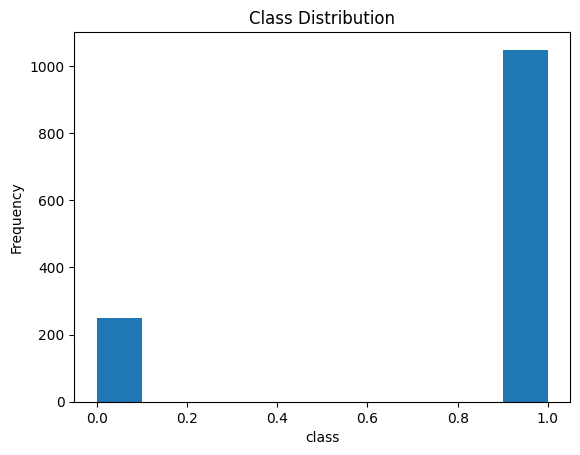

In [137]:
counts, bins = np.histogram(df['category'])
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Class Distribution")
plt.xlabel('class')
plt.ylabel('Frequency')
print("Class 0 samples: ",len(df[df['category']==0]))
print("Class 1 samples: ",len(df[df['category']==1]))
plt.show()



## Preprocess data
1. Clean data
2. remove stop words
3. Apply Stemming (optional)
3. Apply lemmatization (Optional)

In [138]:
import string

table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
string_punctuation_1 = string.punctuation.replace(".","").replace("`","").replace("'","")
table_ = str.maketrans(string_punctuation_1, ' '*len(string_punctuation_1))
printable = set(string.printable)


def clean_data(text):

    sentence = text.lower()
    sentence_no_punct = sentence.translate(table_)
    space_remove = re.sub('\s+',' ', sentence_no_punct)
    return space_remove


In [139]:
df['Transcripts_cleaned'] = df['data'].apply(lambda row: clean_data(row) )

In [140]:
df['Transcripts_cleaned'].iloc[550] , df['category'].iloc[550]

(" oh that kid's gonna get a good spill off of that stool if his mother don't turn around there and catch him . gonna drop whatever he's got in his hands . the little girl's reaching up there to get something from the boy . i think he's gonna land himself on the floor the way he does it . ",
 1)

In [141]:
stemmer = SnowballStemmer('english')
def stem_words(text):
    text = text.split()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [142]:
df['Transcripts_stem'] = df['Transcripts_cleaned'].apply(lambda row: stem_words(row))

In [143]:
df['Transcripts_stem']

0      the scene is in the in the kitchen . the mothe...
1      oh i see the sink is run over . i see the stoo...
2      a boy and a girl are in the kitchen with their...
3      it was summertim and mother and the children w...
4      wait until i put my glass on . oh ‡ there a gi...
                             ...                        
236    pencilq . ‡ well you write with a pencil . wel...
237    treeq what is realli amaz me amaz me to me whe...
238    write me a letter . oh boy ‡ i'm way out today...
239    i write with a pencil . the tree are beauti in...
240    she wrote with a pencil . treeq . the tree is ...
Name: Transcripts_stem, Length: 1299, dtype: object

In [144]:
#Lemmatizing data (optional)

In [145]:
lemmatizer = WordNetLemmatizer()

In [146]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [147]:
df['Transcripts_lem'] = df['Transcripts_cleaned'].apply(lambda row: " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(row)]))

In [148]:
df['Transcripts_lem']

0      the scene is in the in the kitchen . the mothe...
1      oh i see the sink is running over . i see the ...
2      a boy and a girl are in the kitchen with their...
3      it wa summertime and mother and the child were...
4      wait until i put my glass on . oh ‡ there 's a...
                             ...                        
236    pencilq . ‡ well you write with a pencil . wel...
237    treeq what is really amazing me amazing me to ...
238    write me a letter . oh boy ‡ i 'm way out toda...
239    i write with a pencil . the tree are beautiful...
240    she wrote with a pencil . treeq . the tree is ...
Name: Transcripts_lem, Length: 1299, dtype: object

## Deep Learning Approach

In [149]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout,Conv1D, Flatten, MaxPooling1D, Dense, LSTM,Conv1D,MaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.constraints import maxnorm
from keras.preprocessing import sequence
from keras.callbacks import History
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:

X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(df['Transcripts_cleaned'], df['category'], test_size = 0.1, random_state = 0)

In [151]:

tokenizer = Tokenizer(num_words = 2500)
tokenizer.fit_on_texts(X_seq_train)

Xwords_train = tokenizer.texts_to_sequences(X_seq_train)
Xwords_test = tokenizer.texts_to_sequences(X_seq_test)

In [152]:

max_review_length = 100
Xwords_train = sequence.pad_sequences(Xwords_train, maxlen=max_review_length)
Xwords_test = sequence.pad_sequences(Xwords_test, maxlen=max_review_length)

In [153]:
print(Xwords_train.shape)
print(Xwords_test.shape)
print(y_seq_train.shape)
print(y_seq_test.shape)

(1169, 100)
(130, 100)
(1169,)
(130,)


In [154]:
vocab = len(tokenizer.word_index) + 1
vocab

4170

In [155]:

history = History()

### Bidirectional LSTM Model

In [156]:

model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim = vocab, output_dim = 100, input_length=100))
model_bilstm.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_bilstm.summary())

model_bilstm.fit(Xwords_train, y_seq_train, epochs=50, batch_size=256,verbose = 1,callbacks = [history],validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          417000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 651753 (2.49 MB)
Trainable params: 651753 (2.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
5/5 [==============================] - 14s 2s/step - loss: 0.6620 - accuracy: 0.6759 - val_loss: 0.5551 - val_accuracy: 0.8291
Epoch 2/50
5/5 [==============================] - 8s 2s/step - loss: 0.51

In [157]:
eval_list = model_bilstm.evaluate(Xwords_test,y_seq_test)
print('Test Loss: ',eval_list[0])
print('Test Accuracy: ',eval_list[1])

5/5 [==============================] - 0s 58ms/step - loss: 0.6041 - accuracy: 0.8692
Test Loss:  0.6040520071983337
Test Accuracy:  0.8692307472229004


In [158]:
model_bilstm.save('saved_models/model_bilstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 1s 61ms/step


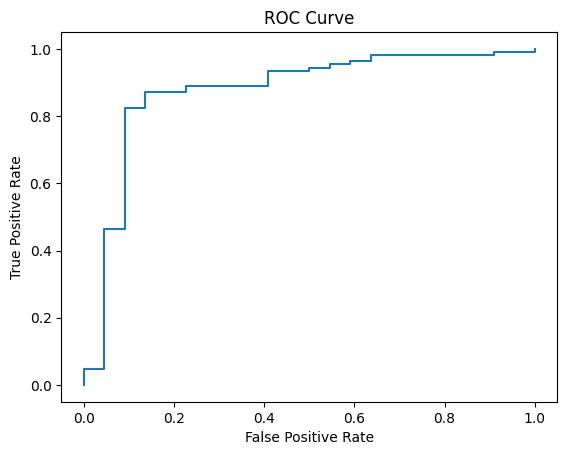

In [159]:
y_pred_probas = model_bilstm.predict(Xwords_test)
#y_pred_probas = [i[0] for i in y_pred_probas]
fpr, tpr, thresholds = roc_curve(y_seq_test, y_pred_probas)
#roc_auc = roc_auc_score(y_test, scores)
plt.plot(fpr, tpr)

plt.title("ROC Curve")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.show()

In [160]:
#y_pred = model_bilstm.predict(Xwords_test)
#y_pred = np.argmax(y_pred, axis=1)
#y_pred = [i[0] for i in y_pred]
y_pred = (y_pred_probas > 0.5).astype("int32")

In [161]:
print(confusion_matrix(y_seq_test, y_pred))
print(classification_report(y_seq_test,y_pred))

[[ 11  11]
 [  6 102]]
              precision    recall  f1-score   support

           0       0.65      0.50      0.56        22
           1       0.90      0.94      0.92       108

    accuracy                           0.87       130
   macro avg       0.77      0.72      0.74       130
weighted avg       0.86      0.87      0.86       130



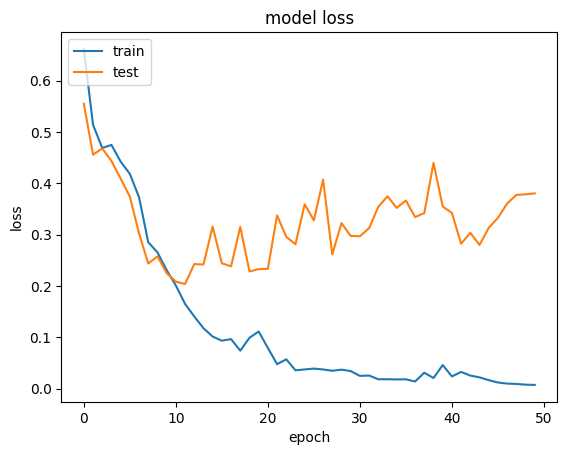

In [162]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

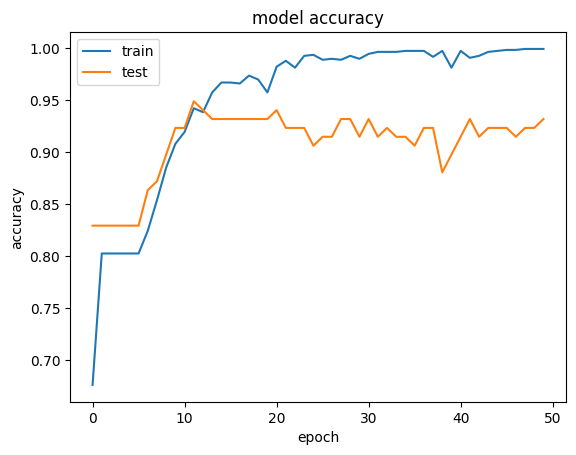

In [163]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()